In [1]:
import sys
sys.path.append('../')
# import our own functions
from utils import *
# for preprocessing
import pandas as pd
pd.set_option('display.max_columns', None)
pd.option_context("display.max_rows", None)
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
from scipy.special import inv_boxcox
from sklearn import preprocessing as ps
from sklearn.impute import KNNImputer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_excel("../../01_Data/02_Processed/processed_v3.xlsx")
df.head()

,FACUL_NUM,DIVISION_NUM,TAG,SEGMENT_LOB,UF_STATUS,CT_STATUS,UWYEAR,CT_PERIOD,MARKET,MAIN_COUNTRY,SUBSECTOR,MAINOCCUPANCY,BUSINESSUNIT,UWCENTER,COVERAGE,PARTTYPE,GUARANTEE,MAIN_PRICING_CATEG,MAIN_PRICING_SUBCATEG,BI_TYPE,BI_PERIOD,INSUREDVALUEPD,INSUREDVALUEBI,TOTALINSUREDVALUE,NBLOCS,OIL,LIMIT,ATTACHMENT,SCOR_SHARE,PREMIUM,MODELED_CAT_EXPLOSS,DISCOUNTS,DEDUCTION,EXT_EXPENSE,WORDING,QUALITY_RISK_MGT,ASSET_QUALITY,BI_MITIGATION,MB_QUALITY,ORIGCCY,TXCHANGE,FXRATEUSD,TOP_MPL,TOP_FMLS,pd_bi,pd,bi,inception_year,inception_month,inception_duration,pricing_duration,diff,premium_level,UWR_cumultive,UWR_avg,UWY_first,YEAR,nb_state,ACCURACY_VALIDATE,YR_BLT,NO_OF_STRY,NO_OF_BLDG,IV_BUILDING,IV_CONTENT,IV_PD,IV_BI_VAL,TIV,INTEREST_DECLARATION,MPL_PD,MPL_PD_PERCEN,MPL_BI,MPL_BI_PERCEN,FMLS_PD,FMLS_PD_PERCEN,FMLS_BI,FMLS_BI_PERCEN,nb_category,LARGEST_UNIT_CAPACITY,EARTHQ_EXP,CYC_EXP,CYCPRO_EXP,FLD_EXP,MHZ_EXP,MHZPRO_EXP,VOL_EXP
0,02F062851,4,Bound,Ppty Non Energy,Active,Finalized,2019,12,ARGENTINA,Argentina,MINING COMPANY,Precious Metals Mines,BS Energy Mining,EMEA,"PD,BI",Excess of Loss,Unspecified,Mining - Hard Rock,Standard,Loss of profit,12.0,4.33e+08,1.81e+08,6.14e+08,1,0.0,3.59e+08,6.60e+06,0.10,51556.79,0.0,0.0,0.09,0.09,Standard,Average,Average,Average,NaN,USD,0.88,1.0,1.99e+08,NaN,NaN,0.9,30.0,2019,4,707,739,32,< 60K,0.46,6.88,12,2019,1,1.0,0.0,0,0,9.92e+08,5.13e+09,6.12e+09,2.31e+09,7.68e+09,19.0,2.00e+07,0.21,1.08e+07,5.26,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,69.63,0.0,69.63,0.0
1,11F008861,1,Bound,Ppty Non Energy,Active,Finalized,2017,12,CANADA,Argentina,MINING COMPANY,Precious Metals Mines,BS Energy Mining,CANADA,"PD,BI",Quota-Share,Unspecified,Mining - Hard Rock,Standard,Loss of profit,12.0,5.37e+08,1.64e+08,7.01e+08,3,0.0,1.86e+08,0.00e+00,0.07,101618.14,0.0,0.0,0.12,0.12,Standard,Average,Average,Average,NaN,USD,0.93,1.0,1.86e+08,NaN,NaN,0.5,30.0,2017,4,1408,1427,19,60K ~ 220K,0.07,0.47,5,2017,3,1.0,0.0,0,0,2.79e+08,2.99e+08,5.78e+08,1.76e+08,7.55e+08,3.0,2.89e+08,50.00,5.87e+07,100.00,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0
2,02F062851,4,Bound,Ppty Non Energy,Active,Finalized,2018,12,ARGENTINA,Argentina,MINING COMPANY,Precious Metals Mines,BS Energy Mining,EMEA,"PD,BI",Excess of Loss,Unspecified,Mining - Hard Rock,Standard,Loss of profit,12.0,4.18e+08,2.40e+08,6.58e+08,1,0.0,3.43e+08,6.32e+06,0.10,45815.49,0.0,0.0,0.13,0.13,Standard,Average,Average,Average,NaN,USD,0.84,1.0,2.57e+08,NaN,NaN,0.8,30.0,2018,3,1103,1103,0,< 60K,0.46,6.88,12,2018,1,1.0,0.0,0,0,9.43e+08,4.88e+09,5.82e+09,2.35e+09,6.79e+09,18.0,2.00e+07,0.22,1.58e+07,5.56,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,69.52,0.0,69.52,0.0
3,FA0020462,1,Bound,Ppty Non Energy,Active,Finalized,2018,12,CANADA,Argentina,MINING COMPANY,Precious Metals Mines,BS Energy Mining,CANADA,"PD,BI",Quota-Share,Unspecified,Mining - Hard Rock,Standard,Loss of profit,12.0,4.90e+08,2.27e+08,7.17e+08,3,0.0,1.68e+08,0.00e+00,0.03,35547.13,0.0,0.0,0.11,0.11,Standard,Average,Average,Average,NaN,USD,0.84,1.0,2.29e+08,NaN,NaN,0.4,30.0,2018,6,982,983,1,< 60K,0.08,0.40,5,2018,3,1.0,0.0,0,0,9.31e+07,4.89e+08,5.82e+08,2.70e+08,8.52e+08,3.0,2.91e+08,50.00,8.99e+07,100.00,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0
4,02F062851,4,Bound,Ppty Non Energy,Active,Finalized,2017,12,ARGENTINA,Argentina,MINING COMPANY,Precious Metals Mines,BS Energy Mining,EMEA,"PD,BI",Excess of Loss,Unspecified,Mining - Hard Rock,Standard,Loss of profit,12.0,4.53e+08,2.53e+08,7.06e+08,1,0.0,3.79e+08,6.97e+06,0.10,69669.24,0.0,0.0,0.14,0.14,Standard,Average,Average,Average,NaN,USD,0.93,1.0,2.35e+08,NaN,NaN,0.9,30.0,2017,3,1468,1469,1,60K ~ 220K,0.46,6.88,12,2017,1,1.0,0.0,0,0,1.33e+09,6.12e+09,7.45e+09,2.93e+09,8.54e+09,23.0,4.88e+07,0.43,8.89e+06,3.26,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,81.98,0.0,75.56,0.0


In [3]:
print(df.shape)
summary(df)

(5192, 85)


,Type,unique value,Available Value,% Availability
Column name,,,,
FACUL_NUM,object,3017,5192,100.00
DIVISION_NUM,int64,12,5192,100.00
TAG,object,4,5192,100.00
SEGMENT_LOB,object,2,5192,100.00
UF_STATUS,object,4,5192,100.00
CT_STATUS,object,3,5192,100.00
UWYEAR,int64,4,5192,100.00
CT_PERIOD,int64,23,5192,100.00
MARKET,object,128,5192,100.00


In [4]:
df.LIMIT.max()

13670264586.8448

In [5]:
df = df[df.SCOR_SHARE < 1]
df = df[df.EXT_EXPENSE < 349550158]
df = df[df.LIMIT < 13670264586]
df[['TOP_FMLS','pd_bi','FMLS_PD_PERCEN','FMLS_BI_PERCEN']] = df[['TOP_FMLS','pd_bi',
                                                                 'FMLS_PD_PERCEN','FMLS_BI_PERCEN']].fillna(0)

## Encoding categorical variables with hashing
#### ! As ensemble regression models are sensitive to sparsity of the data, hashing or label encoding gave us better performance than One-Hot encoding

In [6]:
f = df[['MAIN_PRICING_CATEG','MAIN_PRICING_SUBCATEG','SUBSECTOR']]
f2 = df[['MARKET','MAIN_PRICING_SUBCATEG']]
feature_hash(df, f, max_size=60)
feature_hash(df, f2, max_size=30)
df.drop(['MARKET','MAIN_PRICING_CATEG','MAIN_PRICING_SUBCATEG','SUBSECTOR'], axis=1, inplace=True)

In [7]:
df.head()

,FACUL_NUM,DIVISION_NUM,TAG,SEGMENT_LOB,UF_STATUS,CT_STATUS,UWYEAR,CT_PERIOD,MAIN_COUNTRY,MAINOCCUPANCY,BUSINESSUNIT,UWCENTER,COVERAGE,PARTTYPE,GUARANTEE,BI_TYPE,BI_PERIOD,INSUREDVALUEPD,INSUREDVALUEBI,TOTALINSUREDVALUE,NBLOCS,OIL,LIMIT,ATTACHMENT,SCOR_SHARE,PREMIUM,MODELED_CAT_EXPLOSS,DISCOUNTS,DEDUCTION,EXT_EXPENSE,WORDING,QUALITY_RISK_MGT,ASSET_QUALITY,BI_MITIGATION,MB_QUALITY,ORIGCCY,TXCHANGE,FXRATEUSD,TOP_MPL,TOP_FMLS,pd_bi,pd,bi,inception_year,inception_month,inception_duration,pricing_duration,diff,premium_level,UWR_cumultive,UWR_avg,UWY_first,YEAR,nb_state,ACCURACY_VALIDATE,YR_BLT,NO_OF_STRY,NO_OF_BLDG,IV_BUILDING,IV_CONTENT,IV_PD,IV_BI_VAL,TIV,INTEREST_DECLARATION,MPL_PD,MPL_PD_PERCEN,MPL_BI,MPL_BI_PERCEN,FMLS_PD,FMLS_PD_PERCEN,FMLS_BI,FMLS_BI_PERCEN,nb_category,LARGEST_UNIT_CAPACITY,EARTHQ_EXP,CYC_EXP,CYCPRO_EXP,FLD_EXP,MHZ_EXP,MHZPRO_EXP,VOL_EXP,MAIN_PRICING_CATEG_hash,MAIN_PRICING_SUBCATEG_hash,SUBSECTOR_hash,MARKET_hash
0,02F062851,4,Bound,Ppty Non Energy,Active,Finalized,2019,12,Argentina,Precious Metals Mines,BS Energy Mining,EMEA,"PD,BI",Excess of Loss,Unspecified,Loss of profit,12.0,4.33e+08,1.81e+08,6.14e+08,1,0.0,3.59e+08,6.60e+06,0.10,51556.79,0.0,0.0,0.09,0.09,Standard,Average,Average,Average,NaN,USD,0.88,1.0,1.99e+08,0.0,0.0,0.9,30.0,2019,4,707,739,32,< 60K,0.46,6.88,12,2019,1,1.0,0.0,0,0,9.92e+08,5.13e+09,6.12e+09,2.31e+09,7.68e+09,19.0,2.00e+07,0.21,1.08e+07,5.26,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,69.63,0.0,69.63,0.0,6,6,46,2
1,11F008861,1,Bound,Ppty Non Energy,Active,Finalized,2017,12,Argentina,Precious Metals Mines,BS Energy Mining,CANADA,"PD,BI",Quota-Share,Unspecified,Loss of profit,12.0,5.37e+08,1.64e+08,7.01e+08,3,0.0,1.86e+08,0.00e+00,0.07,101618.14,0.0,0.0,0.12,0.12,Standard,Average,Average,Average,NaN,USD,0.93,1.0,1.86e+08,0.0,0.0,0.5,30.0,2017,4,1408,1427,19,60K ~ 220K,0.07,0.47,5,2017,3,1.0,0.0,0,0,2.79e+08,2.99e+08,5.78e+08,1.76e+08,7.55e+08,3.0,2.89e+08,50.00,5.87e+07,100.00,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,6,6,46,22
2,02F062851,4,Bound,Ppty Non Energy,Active,Finalized,2018,12,Argentina,Precious Metals Mines,BS Energy Mining,EMEA,"PD,BI",Excess of Loss,Unspecified,Loss of profit,12.0,4.18e+08,2.40e+08,6.58e+08,1,0.0,3.43e+08,6.32e+06,0.10,45815.49,0.0,0.0,0.13,0.13,Standard,Average,Average,Average,NaN,USD,0.84,1.0,2.57e+08,0.0,0.0,0.8,30.0,2018,3,1103,1103,0,< 60K,0.46,6.88,12,2018,1,1.0,0.0,0,0,9.43e+08,4.88e+09,5.82e+09,2.35e+09,6.79e+09,18.0,2.00e+07,0.22,1.58e+07,5.56,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,69.52,0.0,69.52,0.0,6,6,46,2
3,FA0020462,1,Bound,Ppty Non Energy,Active,Finalized,2018,12,Argentina,Precious Metals Mines,BS Energy Mining,CANADA,"PD,BI",Quota-Share,Unspecified,Loss of profit,12.0,4.90e+08,2.27e+08,7.17e+08,3,0.0,1.68e+08,0.00e+00,0.03,35547.13,0.0,0.0,0.11,0.11,Standard,Average,Average,Average,NaN,USD,0.84,1.0,2.29e+08,0.0,0.0,0.4,30.0,2018,6,982,983,1,< 60K,0.08,0.40,5,2018,3,1.0,0.0,0,0,9.31e+07,4.89e+08,5.82e+08,2.70e+08,8.52e+08,3.0,2.91e+08,50.00,8.99e+07,100.00,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,6,6,46,22
4,02F062851,4,Bound,Ppty Non Energy,Active,Finalized,2017,12,Argentina,Precious Metals Mines,BS Energy Mining,EMEA,"PD,BI",Excess of Loss,Unspecified,Loss of profit,12.0,4.53e+08,2.53e+08,7.06e+08,1,0.0,3.79e+08,6.97e+06,0.10,69669.24,0.0,0.0,0.14,0.14,Standard,Average,Average,Average,NaN,USD,0.93,1.0,2.35e+08,0.0,0.0,0.9,30.0,2017,3,1468,1469,1,60K ~ 220K,0.46,6.88,12,2017,1,1.0,0.0,0,0,1.33e+09,6.12e+09,7.45e+09,2.93e+09,8.54e+09,23.0,4.88e+07,0.43,8.89e+06,3.26,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,81.98,0.0,75.56,0.0,6,6,46,2


## Encoding with label encoder

In [8]:
encoder = ps.LabelEncoder()
df['UWCENTER'] = encoder.fit_transform(df['UWCENTER'])
df['SEGMENT_LOB'] = encoder.fit_transform(df['SEGMENT_LOB'])
df['CT_STATUS'] = encoder.fit_transform(df['CT_STATUS'])
df['COVERAGE'] = encoder.fit_transform(df['COVERAGE'])
df['BUSINESSUNIT'] = encoder.fit_transform(df['BUSINESSUNIT'])
df['UF_STATUS'] = encoder.fit_transform(df['UF_STATUS'])

In [9]:
df.drop(['MAINOCCUPANCY','OIL','NO_OF_STRY','pd_bi','FXRATEUSD','FMLS_BI','IV_CONTENT',
         'DISCOUNTS','premium_level','ORIGCCY','WORDING','QUALITY_RISK_MGT','PARTTYPE','FMLS_BI_PERCEN',
         'MB_QUALITY','MAIN_COUNTRY','GUARANTEE','TAG','inception_year','BI_TYPE','inception_duration','inception_month',
         'COVERAGE','YEAR','nb_category','BI_MITIGATION','ASSET_QUALITY','SEGMENT_LOB','CT_STATUS','YR_BLT',
         'NO_OF_BLDG','FLD_EXP','MHZ_EXP','CYC_EXP','CYCPRO_EXP','MHZPRO_EXP','VOL_EXP'], axis=1,inplace=True)

## Fix the skewness of the training data with BoxCox

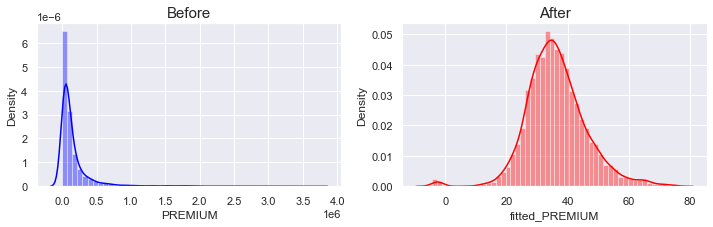

In [10]:
df2 = df
df['fitted_PREMIUM'], lmbda = stats.boxcox(df['PREMIUM'])
fig, ax = plt.subplots(1,2, figsize=(12,3))
sns.distplot(df['PREMIUM'], norm_hist=True, color = 'blue', ax=ax[0]).set_title("Before", fontsize=15)
sns.distplot(df['fitted_PREMIUM'], norm_hist=True, color = 'red', ax=ax[1]).set_title("After", fontsize=15)
plt.show()

In [11]:
df['fitted_TOTALINSUREDVALUE'] = np.log(df['TOTALINSUREDVALUE'] + 1)

In [12]:
df = shuffle(df)
df.drop(['FACUL_NUM','DIVISION_NUM','UWYEAR','PREMIUM','TOTALINSUREDVALUE'], axis=1, inplace=True)

In [13]:
print(df.shape)
df.head()

(5189, 45)


,UF_STATUS,CT_PERIOD,BUSINESSUNIT,UWCENTER,BI_PERIOD,INSUREDVALUEPD,INSUREDVALUEBI,NBLOCS,LIMIT,ATTACHMENT,SCOR_SHARE,MODELED_CAT_EXPLOSS,DEDUCTION,EXT_EXPENSE,TXCHANGE,TOP_MPL,TOP_FMLS,pd,bi,pricing_duration,diff,UWR_cumultive,UWR_avg,UWY_first,nb_state,ACCURACY_VALIDATE,IV_BUILDING,IV_PD,IV_BI_VAL,TIV,INTEREST_DECLARATION,MPL_PD,MPL_PD_PERCEN,MPL_BI,MPL_BI_PERCEN,FMLS_PD,FMLS_PD_PERCEN,LARGEST_UNIT_CAPACITY,EARTHQ_EXP,MAIN_PRICING_CATEG_hash,MAIN_PRICING_SUBCATEG_hash,SUBSECTOR_hash,MARKET_hash,fitted_PREMIUM,fitted_TOTALINSUREDVALUE
296,3,12,0,2,NaN,1.62e+08,NaN,1,6.97e+07,0.00e+00,0.10,0.00,0.13,0.13,0.93,6.97e+07,0.00e+00,0.1,NaN,1475,7,0.00,0.00,5,1,1.00,2.79e+07,1.74e+08,0.00e+00,0.00e+00,1.0,7.50e+07,43.09,0.00e+00,0.00,0.00e+00,0.0,0.0,0.00,0,6,46,21,31.69,18.90
431,0,12,1,0,24.0,1.42e+09,1.51e+09,85,3.92e+08,6.92e+06,0.05,1134.90,0.09,0.09,0.69,1.25e+08,0.00e+00,NaN,NaN,1274,19,0.00,0.00,11,9,0.85,7.08e+08,2.05e+09,2.18e+09,3.86e+09,85.0,1.10e+09,94.40,1.54e+07,95.30,0.00e+00,0.0,0.0,13.10,36,18,45,13,33.54,21.80
4837,1,12,2,4,12.0,4.60e+08,2.21e+08,37,1.05e+08,0.00e+00,0.17,3049.59,0.18,0.18,0.84,6.56e+07,0.00e+00,NaN,NaN,743,-55,0.37,2.62,8,18,1.00,1.56e+08,5.46e+08,2.62e+08,7.74e+08,37.0,4.43e+08,95.00,6.00e+06,95.00,0.00e+00,0.0,0.0,42.04,2,19,7,1,33.03,20.34
1207,0,12,1,2,27.0,1.29e+09,2.61e+08,11,5.72e+08,0.00e+00,0.05,4.88,0.06,0.06,0.88,8.30e+08,0.00e+00,2.6,45.0,472,-21,0.06,1.07,12,3,1.00,1.30e+09,1.47e+09,2.96e+08,1.55e+09,11.0,5.65e+08,93.44,5.39e+07,109.09,0.00e+00,0.0,0.0,0.00,43,10,45,21,41.26,21.16
2433,0,12,3,2,16.0,2.30e+08,4.49e+07,1,2.74e+08,0.00e+00,0.15,60.26,0.00,0.00,0.88,1.02e+08,5.66e+07,0.3,30.0,647,0,0.00,0.00,6,1,1.00,3.91e+07,2.61e+08,5.10e+07,3.12e+08,1.0,6.52e+07,25.00,5.10e+07,100.00,2.61e+07,10.0,75.0,0.00,21,24,32,21,38.23,19.43


## Impute missing data for train / test separately with KNN imputer

In [14]:
train, test = train_test_split(df, test_size=0.15, random_state=42)
knn_imp = KNNImputer(n_neighbors=4, weights='distance')
train_impute = pd.DataFrame(knn_imp.fit_transform(train), columns=df.columns)
test_impute = pd.DataFrame(knn_imp.fit_transform(test), columns=df.columns)

In [15]:
train[['fitted_PREMIUM']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fitted_PREMIUM,4410.0,36.27,9.77,-4.22,30.22,35.48,41.49,75.62


In [16]:
test[['fitted_PREMIUM']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fitted_PREMIUM,779.0,36.55,10.09,-2.91,30.03,35.55,42.3,73.02


train and test data is quite balanced

In [17]:
X_train = train_impute.drop(['fitted_PREMIUM'], axis=1)
y_train = train_impute['fitted_PREMIUM']
X_test = test_impute.drop(['fitted_PREMIUM'], axis=1)
y_test = test_impute['fitted_PREMIUM']

# Model Training

In [18]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, KFold
import xgboost
from xgboost import plot_importance
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import tensorflow as tf, keras 
from tensorflow.keras import layers
from keras.layers import Dropout
from tensorflow.keras.layers.experimental import preprocessing
from keras.wrappers.scikit_learn import KerasRegressor
import joblib
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import StackingRegressor
import shap
shap.initjs()

## Feature selection by Stepwise regression and RFECV

In [19]:
X = df.drop(['fitted_PREMIUM'] ,axis=1)
y = df['fitted_PREMIUM']
knn_imp = KNNImputer(n_neighbors=4, weights='distance')
X_impute = pd.DataFrame(knn_imp.fit_transform(X), columns=X.columns)

In [62]:
# Stepwise feature selection with p-value threshold 0.05
result = stepwise(X_impute, list(y))

Add  TOTALINSUREDVALUE              with p-value 4.28183e-219
Add  bi                             with p-value 1.86733e-91
Add  MODELED_CAT_EXPLOSS            with p-value 5.59738e-82
Add  UWCENTER                       with p-value 3.2159e-59
Add  BUSINESSUNIT                   with p-value 8.03679e-46
Add  UF_STATUS                      with p-value 2.39397e-30
Add  LIMIT                          with p-value 3.75597e-25
Add  SCOR_SHARE                     with p-value 1.89834e-35
Add  ATTACHMENT                     with p-value 1.88297e-33
Add  EXT_EXPENSE                    with p-value 2.46928e-23
Add  pricing_duration               with p-value 7.98081e-15
Add  CT_PERIOD                      with p-value 1.95004e-14
Add  BI_PERIOD                      with p-value 8.25092e-11
Add  nb_state                       with p-value 6.73302e-08
Add  MAIN_PRICING_SUBCATEG_hash     with p-value 1.43809e-07
Add  diff                           with p-value 1.93108e-05
Add  MARKET_hash        

In [ ]:
# RFECV with xgboost regressor
selector_xgb = RFECV(xgboost.XGBRegressor(max_depth=4, n_estimators=600, eta=0.2, grow_policy='lossguide',
                           max_leaves=4, reg_lambda=0, reg_alpha=3, eval_metric=["rmse"]), step=1, cv=5)
selector_xgb = selector_xgb.fit(X_impute, y)
rfcv_xgb_result = pd.DataFrame([selector_xgb.support_, selector_xgb.ranking_], columns=X_train.columns.values).transpose().rename(columns={0:'Support', 1:'Rank'})
rfcv_xgb_result[rfcv_xgb_result.Support == False]

In [ ]:
# RFECV with catboost regressor
selector_cb = RFECV(CatBoostRegressor(iterations=1000, depth=4, l2_leaf_reg=2, 
                                   learning_rate=0.4, loss_function='RMSE', verbose=False), step=1, cv=5)
selector_cb = selector_cb.fit(X_impute, y)
rfcv_cb_result = pd.DataFrame([selector_cb.support_, selector_cb.ranking_], columns=X_train.columns.values).transpose().rename(columns={0:'Support', 1:'Rank'})
rfcv_cb_result[rfcv_cb_result.Support == False]
                    

In [20]:
X_train.drop(['UF_STATUS','FMLS_PD_PERCEN','TIV','ACCURACY_VALIDATE','FMLS_PD','MPL_PD','NBLOCS','IV_BI_VAL','diff','MAIN_PRICING_SUBCATEG_hash','IV_PD','SUBSECTOR_hash','BI_PERIOD','CT_PERIOD','nb_state','TOP_FMLS','MPL_BI_PERCEN','UWY_first','UWR_cumultive','pricing_duration'], axis=1, inplace=True)
X_test.drop(['UF_STATUS','FMLS_PD_PERCEN','TIV','ACCURACY_VALIDATE','FMLS_PD','MPL_PD','NBLOCS','IV_BI_VAL','diff','MAIN_PRICING_SUBCATEG_hash','IV_PD','SUBSECTOR_hash','BI_PERIOD','CT_PERIOD','nb_state','TOP_FMLS','MPL_BI_PERCEN','UWY_first','UWR_cumultive','pricing_duration'], axis=1, inplace=True)
X_impute.drop(['UF_STATUS','FMLS_PD_PERCEN','TIV','ACCURACY_VALIDATE','FMLS_PD','MPL_PD','NBLOCS','IV_BI_VAL','diff','MAIN_PRICING_SUBCATEG_hash','IV_PD','SUBSECTOR_hash','BI_PERIOD','CT_PERIOD','nb_state','TOP_FMLS','MPL_BI_PERCEN','UWY_first','UWR_cumultive','pricing_duration'], axis=1, inplace=True)


## Parameter tuning with Grid Search and KFold

In [ ]:
cv = KFold(n_splits=3, shuffle=True, random_state=42)
xgb_best = xgboost.XGBRegressor()
xgb_cv = GridSearchCV(xgb_best, {"max_depth": [4, 5, 6], "n_estimators":[600,700], "max_leaves":[4, 5],
                                "reg_alpha":[2, 3], "grow_policy":['lossguide'], "reg_lambda":[0], "eval_metric":["rmse"]},
                      cv=cv, verbose=0, n_jobs=-1).fit(X_impute, y)

In [ ]:
pd.DataFrame(xgb_cv.cv_results_).sort_values("mean_test_score", ascending = False).head(3)

In [ ]:
xgb_cv.best_params_

In [51]:
cb_best = CatBoostRegressor()
cb_cv = GridSearchCV(cb_best, {"max_depth": [4, 5, 6], "iterations":[1000], "learning_rate":[0.2, 0.3], "l2_leaf_reg":[2,3], "verbose":[False]},
                      cv=cv, verbose=0, n_jobs=-1).fit(X_impute, y)

In [52]:
pd.DataFrame(cb_cv.cv_results_).sort_values("mean_test_score", ascending = False).head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_iterations,param_l2_leaf_reg,param_learning_rate,param_max_depth,param_verbose,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
7,14.67,0.12,7.82e-03,4.48e-04,1000,3,0.2,5,False,"{'iterations': 1000, 'l2_leaf_reg': 3, 'learni...",0.87,0.86,0.88,0.87,6.52e-03,1
8,19.13,0.30,7.63e-03,1.11e-03,1000,3,0.2,6,False,"{'iterations': 1000, 'l2_leaf_reg': 3, 'learni...",0.87,0.87,0.87,0.87,2.42e-03,2
0,16.72,0.05,9.08e-03,1.54e-04,1000,2,0.2,4,False,"{'iterations': 1000, 'l2_leaf_reg': 2, 'learni...",0.87,0.86,0.88,0.87,5.89e-03,3


In [53]:
cb_cv.best_params_

{'iterations': 1000,
 'l2_leaf_reg': 3,
 'learning_rate': 0.2,
 'max_depth': 5,
 'verbose': False}

In [73]:
rf_best = RandomForestRegressor()
rf_cv = GridSearchCV(rf_best, {"max_depth": [3, 4, 5], "n_estimators":[800, 1000], "min_samples_leaf":[3, 4, 5]},
                      cv=cv, verbose=0, n_jobs=-1).fit(X_train, y_train)

In [74]:
pd.DataFrame(rf_cv.cv_results_).sort_values("mean_test_score", ascending = False).head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
12,24.45,1.35,0.17,9.84e-03,5,3,800,"{'max_depth': 5, 'min_samples_leaf': 3, 'n_est...",0.66,0.66,0.66,0.66,1.94e-03,1
13,32.16,0.27,0.19,3.15e-03,5,3,1000,"{'max_depth': 5, 'min_samples_leaf': 3, 'n_est...",0.66,0.66,0.66,0.66,1.44e-03,2
15,35.73,0.42,0.22,1.64e-02,5,4,1000,"{'max_depth': 5, 'min_samples_leaf': 4, 'n_est...",0.66,0.66,0.66,0.66,1.46e-03,3


In [75]:
rf_cv.best_params_

{'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 800}

In [89]:
def try_model(layers):
    model = keras.Sequential()
    for i, nodes in enumerate(layers):
        if i == 0:
            keras.layers.Dense(nodes, input_dim=X_train.shape[1], activation='relu')
            keras.layers.Dropout(0.3),
        else:
            keras.layers.Dense(nodes, activation='relu')
            keras.layers.Dropout(0.3)
    model.compile(loss='mean_absolute_error', optimizer='adam',metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

dnn_best = KerasRegressor(build_fn=try_model, verbose=0)
dnn_cv = GridSearchCV(dnn_best, {"layers":[(40,30),(30,20)],"batch_size":[300,500], "epochs":[80]},
                      cv=2, verbose=0, n_jobs=-1).fit(X_train, y_train)

In [90]:
pd.DataFrame(dnn_cv.cv_results_).sort_values("mean_test_score", ascending = False).head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_epochs,param_layers,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,1.16,1.41e-03,0.22,2.68e-03,300,80,"(40, 30)","{'batch_size': 300, 'epochs': 80, 'layers': (4...",-2.71e+09,-2.04e+09,-2.38e+09,3.36e+08,1
1,1.14,7.20e-03,0.21,6.41e-04,300,80,"(30, 20)","{'batch_size': 300, 'epochs': 80, 'layers': (3...",-2.71e+09,-2.04e+09,-2.38e+09,3.36e+08,1
2,0.73,4.45e-03,0.25,5.47e-04,500,80,"(40, 30)","{'batch_size': 500, 'epochs': 80, 'layers': (4...",-2.71e+09,-2.04e+09,-2.38e+09,3.36e+08,1


In [91]:
dnn_cv.best_params_

{'batch_size': 300, 'epochs': 80, 'layers': (40, 30)}

## Train models with the best parameters

## XGBoost

In [21]:
xgb = xgboost.XGBRegressor(max_depth=4, n_estimators=700, eta=0.2, grow_policy='lossguide',
                           max_leaves=5, reg_lambda=0, reg_alpha=3, eval_metric=["rmse"]).fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)

In [22]:
y_test__ = inv_boxcox(y_test, 0.17700863235182274)
y_xgb__ = inv_boxcox(pred_xgb, 0.17700863235182274)

In [23]:
y_test__.max()

2895431.69570719

In [24]:
xgb_rmse = np.sqrt(mean_squared_error(y_test, pred_xgb))
print("RMSE: %f" % (xgb_rmse))
minmax = max(df['fitted_PREMIUM']) - min(df['fitted_PREMIUM'])
xgb_nrmse = xgb_rmse / minmax
print("Normalized RMSE: %f" % (xgb_nrmse))

RMSE: 3.576573
Normalized RMSE: 0.044796


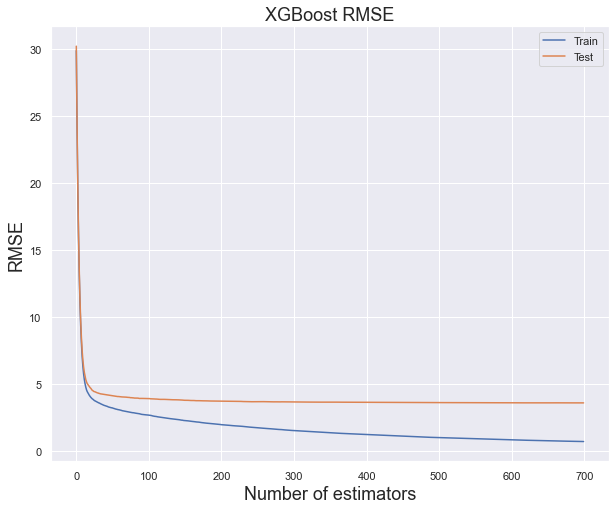

In [25]:
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb.fit(X_train, y_train, eval_metric=["rmse"], eval_set=eval_set, verbose=False)
results = xgb.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.xlabel('Number of estimators',fontsize=18)
plt.ylabel('RMSE',fontsize=18)
plt.title('XGBoost RMSE',fontsize=18)
plt.show()

In [26]:
weights_xgb = eli5.explain_weights_xgboost(xgb, top=50, feature_names = X_train.columns.tolist())
weights_xgb

Weight,Feature
0.3333,fitted_TOTALINSUREDVALUE
0.1108,SCOR_SHARE
0.0866,ATTACHMENT
0.0604,INSUREDVALUEPD
0.0504,BUSINESSUNIT
0.0452,DEDUCTION
0.0331,MODELED_CAT_EXPLOSS
0.0268,UWR_avg
0.0250,LARGEST_UNIT_CAPACITY
0.0249,UWCENTER


## CatBoost

In [27]:
cb = CatBoostRegressor(iterations=1000, depth=5, l2_leaf_reg=3, learning_rate=0.2, loss_function='RMSE', verbose=False).fit(X_train, y_train,plot=True)
pred_cb = cb.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [28]:
cb_rmse = np.sqrt(mean_squared_error(y_test, pred_cb))
print("RMSE: %f" % (cb_rmse))
cb_nrmse = cb_rmse / minmax
print("Normalized RMSE: %f" % (cb_nrmse))

RMSE: 3.595615
Normalized RMSE: 0.045035


In [29]:
weights_cb = eli5.explain_weights_catboost(cb, top=50, feature_names = X_train.columns.tolist())
weights_cb

Weight,Feature
0.2421,fitted_TOTALINSUREDVALUE
0.1261,SCOR_SHARE
0.0593,INSUREDVALUEPD
0.0544,MODELED_CAT_EXPLOSS
0.0480,DEDUCTION
0.0373,ATTACHMENT
0.0341,MPL_BI
0.0332,pd
0.0314,BUSINESSUNIT
0.0300,TXCHANGE


In [30]:
explainer_xgb = shap.TreeExplainer(xgb)
shap_values_xgb = explainer_xgb.shap_values(X_train)
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[0,:], X_train.iloc[0,:])

In [31]:
explainer_cb = shap.TreeExplainer(cb)
shap_values_cb = explainer_cb.shap_values(X_train)
shap.force_plot(explainer_cb.expected_value, shap_values_cb[0,:], X_train.iloc[0,:])

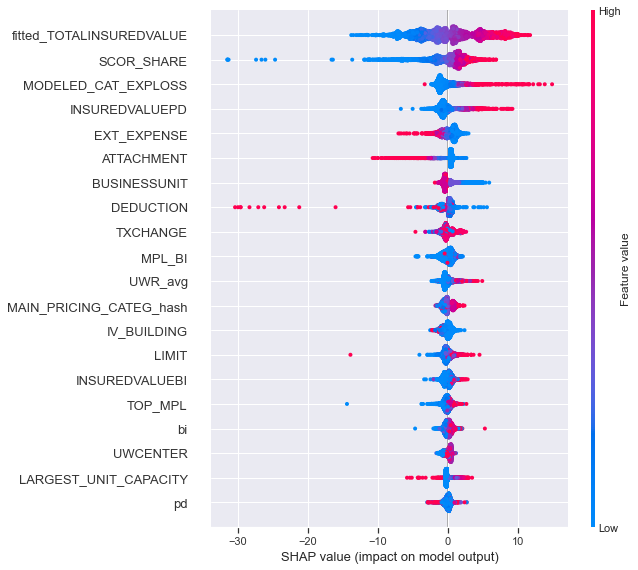

In [32]:
shap.summary_plot(shap_values_xgb, X_train)

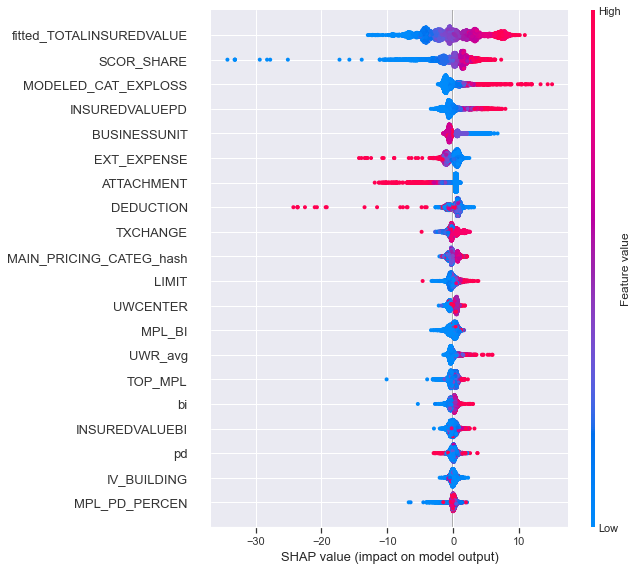

In [33]:
shap.summary_plot(shap_values_cb, X_train)

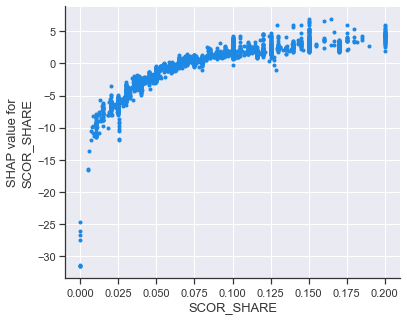

In [34]:
shap.dependence_plot('SCOR_SHARE', shap_values_xgb, X_train, interaction_index=None)

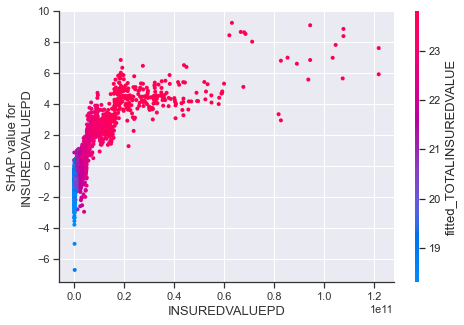

In [39]:
shap.dependence_plot('INSUREDVALUEPD', shap_values_xgb, X_train)

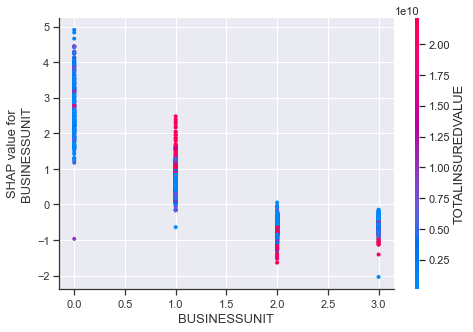

In [75]:
shap.dependence_plot('BUSINESSUNIT', shap_values_xgb, X_train,)

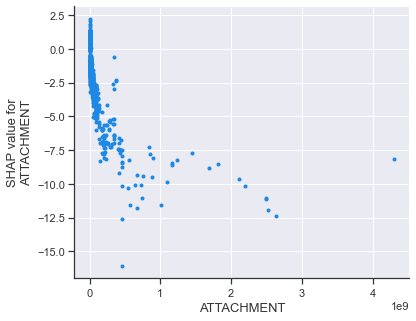

In [76]:
shap.dependence_plot('ATTACHMENT', shap_values_xgb, X_train, interaction_index=None)

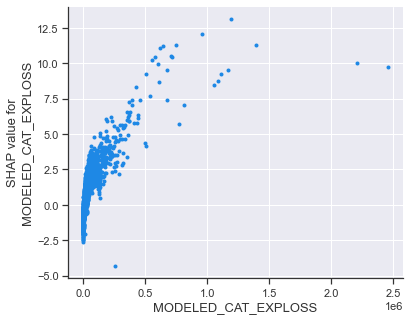

In [77]:
shap.dependence_plot('MODELED_CAT_EXPLOSS', shap_values_xgb, X_train, interaction_index=None)

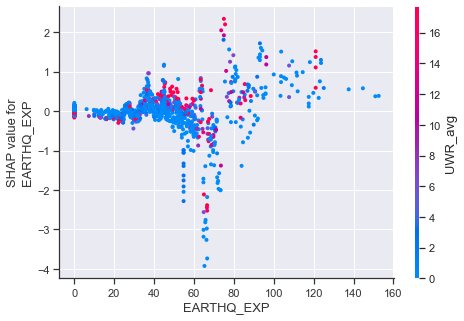

In [78]:
shap.dependence_plot('EARTHQ_EXP', shap_values_xgb, X_train)

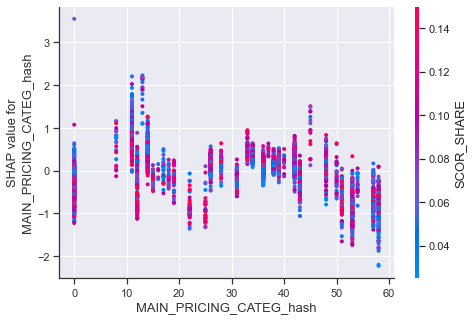

In [79]:
shap.dependence_plot('MAIN_PRICING_CATEG_hash', shap_values_xgb, X_train)

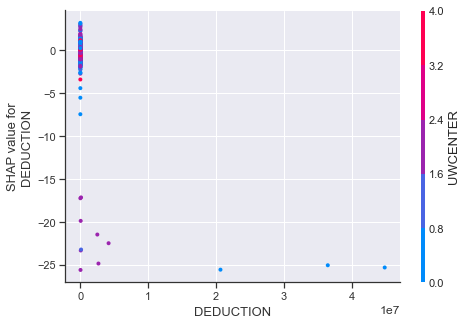

In [91]:
shap.dependence_plot('DEDUCTION', shap_values_xgb, X_train)

In [41]:
df2.to_excel('../../01_Data/02_Processed/tmp.xlsx',index=False)

In [85]:
def Coef_SHAP(df_shap, df):
    sns.set(font_scale=1.1)
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # check the coeficient direction, and color differently
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr'] > 0, 'lightcoral','skyblue')
    
    # plot
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(8,8),legend=False)
    ax.set_xlabel("Feature Importance (Red = Positive Impact, Blue = Negative Impact)")
    ax.set_ylabel("")

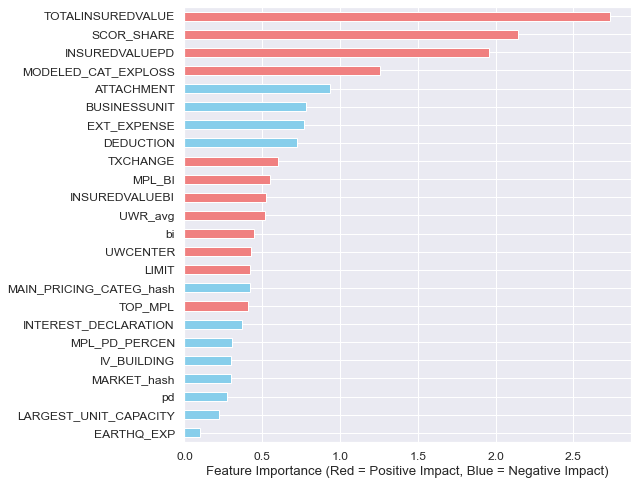

In [87]:
Coef_SHAP(shap_values_cb, X_train)

## Random Forest

In [81]:
rf = RandomForestRegressor(max_depth=5, min_samples_leaf=3, n_estimators=800).fit(X_train, y_train)
pred_rf = rf.predict(X_test)

In [82]:
rf_rmse = np.sqrt(mean_squared_error(y_test, pred_rf))
print("RMSE: %f" % (rf_rmse))
rf_nrmse = rf_rmse / minmax
print("Normalized RMSE: %f" % (rf_nrmse))

RMSE: 5.363002
Normalized RMSE: 0.067171


In [83]:
perm_rf = PermutationImportance(rf).fit(X_train, y_train)
weights_rf = eli5.show_weights(perm_rf, top=50, feature_names = X_train.columns.tolist())
weights_rf

Weight,Feature
0.8889 ± 0.0128,TOTALINSUREDVALUE
0.2015 ± 0.0185,SCOR_SHARE
0.0738 ± 0.0037,INSUREDVALUEPD
0.0306 ± 0.0034,ATTACHMENT
0.0296 ± 0.0023,UWR_avg
0.0171 ± 0.0007,EXT_EXPENSE
0.0169 ± 0.0015,DEDUCTION
0.0168 ± 0.0012,IV_BUILDING
0.0069 ± 0.0007,LARGEST_UNIT_CAPACITY
0.0053 ± 0.0004,TXCHANGE


## DNN

In [31]:
X_train.shape[1]

24

In [32]:
normalizer = preprocessing.Normalization(input_shape=(24,))
normalizer.adapt(np.array(X_train))
dnn = keras.Sequential([
    normalizer,
    keras.layers.Dense(40, input_dim=X_train.shape[1], activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1)])
dnn.compile(loss='mean_absolute_error', optimizer='adam',metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [33]:
dnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 24)                49        
_________________________________________________________________
dense (Dense)                (None, 40)                1000      
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1230      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 2,310
Trainable params: 2,261
Non-trainable params: 49
_____________________________________________________

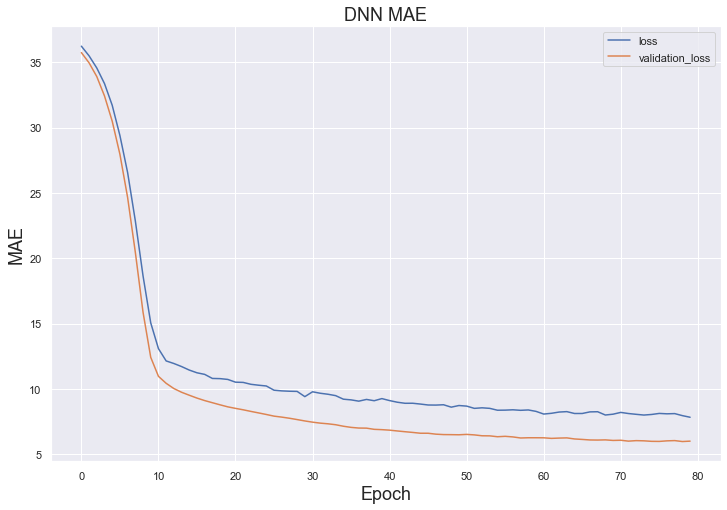

In [34]:
fitted = dnn.fit(X_train, y_train, validation_split=0.10, verbose=0, epochs=80, batch_size=300)
plot_loss(fitted)

In [35]:
def create_model():
    model = keras.Sequential([
        normalizer,
        keras.layers.Dense(40, input_dim=X_train.shape[1], activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(30, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1)])
    model.compile(loss='mean_absolute_error', optimizer='adam',metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [36]:
pred_dnn = dnn.predict(X_test)
dnn_rmse = np.sqrt(mean_squared_error(y_test, pred_dnn))
print("RMSE: %f" % (dnn_rmse))
dnn_nrmse = dnn_rmse / minmax
print("Normalized RMSE: %f" % (dnn_nrmse))

RMSE: 593.764154
Normalized RMSE: 7.358342


In [97]:
dnn2 = KerasRegressor(build_fn=create_model)
dnn2.fit(X_train, y_train, epochs=80, batch_size=300, verbose=0)
perm_dnn = PermutationImportance(dnn2).fit(X_train, y_train)
weights_dnn = eli5.show_weights(perm_dnn, feature_names = X_train.columns.tolist())

138/138 [==============================] - 0s 619us/step - loss: 5.6306 - root_mean_squared_error: 7.8316


In [98]:
weights_dnn

Weight,Feature
1.2948 ± 0.0696,INSUREDVALUEPD
0.7138 ± 0.0337,LIMIT
0.4636 ± 0.0408,bi
0.4479 ± 0.0236,MODELED_CAT_EXPLOSS
0.3670 ± 0.0209,BUSINESSUNIT
0.3659 ± 0.0524,UWCENTER
0.2527 ± 0.0228,SCOR_SHARE
0.2448 ± 0.0511,pricing_duration
0.1953 ± 0.0134,ATTACHMENT
0.1300 ± 0.0397,MARKET_hash


## Other basic models
### Lasso and Baysian Ridge

In [38]:
ls = linear_model.Lasso(alpha=0.2).fit(X_train, y_train)
pred_ls = ls.predict(X_test)
ls_rmse = np.sqrt(mean_squared_error(y_test, pred_ls))
print("RMSE: %f" % (ls_rmse))
ls_nrmse = ls_rmse / minmax
print("Normalized RMSE: %f" % (ls_nrmse))
perm_ls = PermutationImportance(ls).fit(X_train, y_train)
weights_ls = eli5.show_weights(perm_ls, feature_names = X_train.columns.tolist())
weights_ls

RMSE: 7.817774
Normalized RMSE: 0.096883


Weight,Feature
0.6801 ± 0.0656,TOTALINSUREDVALUE
0.1670 ± 0.0111,INSUREDVALUEPD
0.1044 ± 0.0076,MODELED_CAT_EXPLOSS
0.0880 ± 0.0057,bi
0.0592 ± 0.0044,UWCENTER
0.0450 ± 0.0067,LIMIT
0.0375 ± 0.0023,ATTACHMENT
0.0291 ± 0.0024,BUSINESSUNIT
0.0134 ± 0.0021,DEDUCTION
0.0110 ± 0.0023,MARKET_hash


In [39]:
br = linear_model.BayesianRidge(normalize=True).fit(X_train, y_train)
pred_br = br.predict(X_test)
br_rmse = np.sqrt(mean_squared_error(y_test, pred_br))
print("RMSE: %f" % (br_rmse))
br_nrmse = br_rmse / minmax
print("Normalized RMSE: %f" % (br_nrmse))
perm_br = PermutationImportance(br).fit(X_train, y_train)
weights_br = eli5.show_weights(perm_br, feature_names = X_train.columns.tolist())
weights_br

RMSE: 7.608164
Normalized RMSE: 0.094286


Weight,Feature
0.0940 ± 0.0097,bi
0.0830 ± 0.0048,MODELED_CAT_EXPLOSS
0.0651 ± 0.0015,LIMIT
0.0528 ± 0.0060,SCOR_SHARE
0.0421 ± 0.0103,TOTALINSUREDVALUE
0.0386 ± 0.0065,ATTACHMENT
0.0363 ± 0.0045,BUSINESSUNIT
0.0347 ± 0.0021,UWCENTER
0.0216 ± 0.0022,INSUREDVALUEPD
0.0137 ± 0.0036,MARKET_hash


### SVM

In [43]:
svm = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2)).fit(X_train, y_train)
pred_svm = svm.predict(X_test)
svm_rmse = np.sqrt(mean_squared_error(y_test, pred_svm))
print("RMSE: %f" % (svm_rmse))
svm_nrmse = svm_rmse / minmax
print("Normalized RMSE: %f" % (svm_nrmse))
perm_svm = PermutationImportance(svm).fit(X_train, y_train)
weights_svm = eli5.show_weights(perm_svm, feature_names = X_train.columns.tolist())
weights_svm

RMSE: 6.664534
Normalized RMSE: 0.082592


Weight,Feature
0.1161 ± 0.0077,TOTALINSUREDVALUE
0.1086 ± 0.0073,INSUREDVALUEPD
0.1084 ± 0.0079,SCOR_SHARE
0.0990 ± 0.0040,LIMIT
0.0673 ± 0.0092,MODELED_CAT_EXPLOSS
0.0383 ± 0.0030,bi
0.0379 ± 0.0031,UWCENTER
0.0318 ± 0.0035,ATTACHMENT
0.0299 ± 0.0034,INSUREDVALUEBI
0.0296 ± 0.0030,BUSINESSUNIT


## Stacking

In [88]:
estimators = [('cb', cb),('xgb', xgb)]
stack = StackingRegressor(estimators=estimators, final_estimator=rf).fit(X_train, y_train)
pred_stack = stack.predict(X_test)

In [89]:
stack_rmse = np.sqrt(mean_squared_error(y_test, pred_stack))
print("RMSE: %f" % (stack_rmse))
stack_nrmse = stack_rmse / minmax
print("Normalized RMSE: %f" % (stack_nrmse))

RMSE: 3.311947
Normalized RMSE: 0.041482


In [90]:
perm_stack = PermutationImportance(stack).fit(X_train, y_train)
weights_stack = eli5.show_weights(perm_stack, feature_names = X_train.columns.tolist())
weights_stack

Weight,Feature
0.3643 ± 0.0102,TOTALINSUREDVALUE
0.2411 ± 0.0043,SCOR_SHARE
0.1179 ± 0.0030,INSUREDVALUEPD
0.0724 ± 0.0036,MODELED_CAT_EXPLOSS
0.0716 ± 0.0027,ATTACHMENT
0.0594 ± 0.0019,EXT_EXPENSE
0.0437 ± 0.0018,DEDUCTION
0.0268 ± 0.0009,BUSINESSUNIT
0.0241 ± 0.0013,LIMIT
0.0187 ± 0.0008,UWR_avg


# Performance

,Model,RMSE,Normalized RMSE
0,Stack,3.34,0.04
1,CatBoost,3.42,0.04
2,XGBoost,3.51,0.04
3,Random Forest,5.82,0.07
4,SVM,6.66,0.08
5,BaysienRidge,7.61,0.09
6,Lasso,7.82,0.10


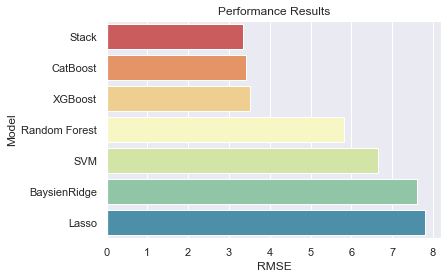

In [44]:
result = {'Model': ['Lasso','BaysienRidge','SVM','XGBoost', 'CatBoost', 'Random Forest','Stack'],
          'RMSE' : [ls_rmse, br_rmse, svm_rmse, xgb_rmse, cb_rmse, rf_rmse, stack_rmse],
          'Normalized RMSE' : [ls_nrmse, br_nrmse, svm_nrmse, xgb_nrmse, cb_nrmse, rf_nrmse, stack_nrmse],}
result_df = pd.DataFrame(result).sort_values('RMSE').sort_values(by='Normalized RMSE').reset_index(drop=True)
sns.barplot(data=result_df, y='Model', x='RMSE', palette="Spectral")
plt.title('Performance Results')
result_df

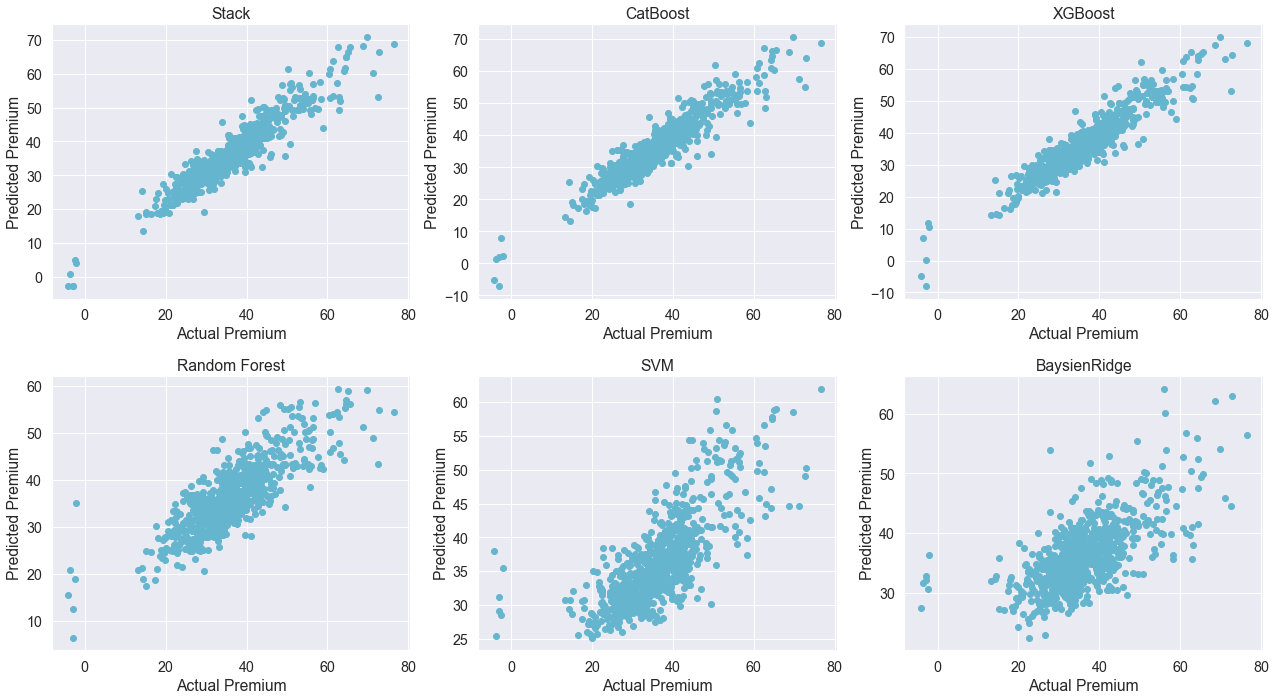

In [45]:
sns.set(font_scale=1.3)
fig, ax = plt.subplots(2,3, figsize=(18,10))
y_preds = [pred_stack, pred_cb, pred_xgb, pred_rf, pred_svm, pred_br]
models = ['Stack','CatBoost','XGBoost','Random Forest','SVM','BaysienRidge']
i = 0
for r in range(2):
    for c in range(3):
        ax[r,c].scatter(y_test, y_preds[i], color="c")
        ax[r,c].set_title(models[i])
        ax[r,c].set_xlabel('Actual Premium')
        ax[r,c].set_ylabel('Predicted Premium')
        i += 1
plt.tight_layout()

## Train Top Models with whole dataset

In [67]:
X_impute.shape

(5192, 24)

In [68]:
cb2 = CatBoostRegressor(iterations=1000, depth=5, l2_leaf_reg=3, learning_rate=0.2, loss_function='RMSE', verbose=False).fit(X_impute, y)
xgb2 = xgboost.XGBRegressor(max_depth=4, n_estimators=700, eta=0.2, grow_policy='lossguide',
                           max_leaves=5, reg_lambda=0, reg_alpha=3, eval_metric=["rmse"]).fit(X_impute, y)
rf2 = RandomForestRegressor(max_depth=5, min_samples_leaf=3, n_estimators=800).fit(X_impute, y)
estimators = [('cb', cb2),('xgb', xgb2)]
stack2 = StackingRegressor(estimators=estimators, final_estimator=rf2).fit(X_impute, y)

In [69]:
# Save the best model
joblib.dump(cb2, '../../03_Model/cb_reg_030821.pkl', compress = 1)
joblib.dump(xgb2, '../../03_Model/xgb_reg_030821.pkl', compress = 1)
joblib.dump(stack2, '../../03_Model/stack_reg_030821_best.pkl', compress = 1)

['../../03_Model/stack_reg_030821_best.pkl']